## MA8701 Project 1

### Gunnar Grotmol, Petter Tinius Melbye and Casper Stenersen

In this report we have chosen to analyse the Facebook Comment Volume Dataset (https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime?fbclid=IwAR1LxTCwJP5jyCXwcrWUa575xqqmIRLJ9fOcyLsP9mrwmC65N3DvWHEHT_I). Instances in this dataset contain features extracted from facebook posts. The task associated with the data is to predict how many comments the post will receive. 

The dataset contains 28 features and 40949 observations. We considered ridge, lasso and elastic net in order to deal with multicollinearity. However, we have focused on lasso for this exercise. 

In [1]:
#!pip install swiftviz
#!pip install mlxtend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels.api as sm



from sklearn.linear_model import Lasso,LassoCV, lasso_path,LogisticRegression,LogisticRegressionCV 

import swiftviz as sv #pip install swiftviz
from mlxtend.plotting import plot_confusion_matrix

from sklearn.svm import l1_min_c
from time import time


sns.set_style("darkgrid")

In [2]:

def import_dataset(filename):
    return pd.read_csv(filename)

def regression_results(y_true, y_pred):
    import sklearn as sk 

    # Regression metrics
    explained_variance = sk.metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = sk.metrics.mean_absolute_error(y_true, y_pred) 
    mse = sk.metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error = sk.metrics.mean_squared_log_error(y_true, y_pred)
    #median_absolute_error = sk.metrics.median_absolute_error(y_true, y_pred)
    r2=sk.metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
   # print("median_absolute_error", round(median_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


        

### Exploratory Analysis

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique() 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

Let's take a quick look at what the data looks like:

In [4]:
df=pd.read_csv('Dataset.csv')
df.head()

FileNotFoundError: [Errno 2] File b'Dataset.csv' does not exist: b'Dataset.csv'

In [ ]:
df.columns

Distribution graphs (histogram/bar graph) of sampled columns:

In [ ]:
plotPerColumnDistribution(df, 28, 4)


Next we look at the properties of the different columns, with regard to minimum and maximum value, mean, standard deviation etc.

In [ ]:
df.describe()

Now we look at missing values. We replace the missing values with mean of column. 

In [ ]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

Below we observe that columns with missing values are of type float64, and thus it is reasonable to replace missing values with column means. 

In [ ]:
df.info()

## Fill missing values with column mean

In [ ]:
# Firstly, we select numeric columns.
numeric = df.select_dtypes(include=np.number)
numeric_columns = numeric.columns
# Then, we fill the NaN values of numeric columns with the average value, given by the df.mean() function
df[numeric_columns] = df[numeric_columns].fillna(df.mean())
# Now, we can check whether the NaN values in numeric columns have been removed.
df[numeric_columns].isna().sum()/len(df)*100

In the plots below we plot the correlation matrix. To see how many were very correlated, a correlation matrix only showing the correlations above 0.7 was also plotted. We see that the perimeter 

In [ ]:
corr_matrix = df.corr()
fig, axs = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True)

In [ ]:
threshold = 0.7
cond_corr_matrix = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]


fig, axs = plt.subplots(figsize=(20, 10))
sns.heatmap(cond_corr_matrix, annot=True)

That is, there seems to be low correlation. However, we might try ridge, lasso or elastic net to remove variables.

## Analysis

It is important to standardize the features by removing the mean and scaling to unit variance. The L1 (Lasso) and L2 (Ridge) regularizers of linear models assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. Split the data set into train and test sets (use X_train, X_test, y_train, y_test), with the first 75% of the data for training and the remaining for testing

We will start by fitting a regular regression model, then look into different regularization techniques. First, the explanatory variables or scaled, so the same data set can be used for all methods.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df.loc[:, df.columns != 'output'] = scaler.fit_transform(df.loc[:, df.columns != 'output'])

X = df.drop(['output'], axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
print(X_train.shape)
print(X_test.shape)

### Linear regression

We first fit a linear regression as bencmark. 

In [ ]:
from statsmodels.api import OLS

#lm = LinearRegression(normalize=False, fit_intercept=True, n_jobs=-1)
model = OLS(y_train,X_train)
results = model.fit()
results.summary()

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
ypred = reg.predict(X_test)
regression_results(y_test, ypred)

## Lasso

The best_estimator_ belonging to GridSearchCV can be used to find the value of lambda yielding the highest MSE, but as we are interested in selecting as few predictors as possible for the final model and to obtain a better generalization performance, we apply the one-standard-error-rule. The following plot shows average MSE with 1sd bands for different values of lambda. 

The maximal penalty yielding nonzero coefficients for the lasso as implemented in sklearn is np.abs(X.T.dot(Y)).max() / len(X).

In [ ]:
l1_min_c_ = np.abs(X.T.dot(y)).max() / len(X) 
l1_min_c_

In [ ]:
lambdas = l1_min_c_ * np.logspace(15, -5, 60)

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV


estimator = Lasso(tol=0.01)
param_grid = {"alpha" : lambdas}
param_grid


In [371]:
n_folds = 10
cv = GridSearchCV(estimator, param_grid, cv=n_folds, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417132.0944654457, tolerance: 358470.1751705924
  positive)
/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 405106.220432017, tolerance: 351777.1662369756
  positive)
/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495243.7800692506, tolerance: 347969.5688509409
  positive)
/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not c

KeyboardInterrupt: 

In [365]:
scores = -cv.cv_results_['mean_test_score']
scores_std = cv.cv_results_['std_test_score']

best_lambd = cv.best_params_['alpha']

best_lambd

11748.23924810008

In [366]:
#Code to find one sd rule lambda

index_best = np.argmax(cv.cv_results_['mean_test_score']) #index of best one
errorbest = -cv.cv_results_['mean_test_score'][index_best]
sdbest = cv.cv_results_['std_test_score'][index_best]

upper_bound = errorbest+sdbest

onesd = best_lambd #start at best and move to the left
erroronesd = errorbest
i = index_best

for j in range(len(lambdas)):
    i=i-1
    onesd= lambdas[i]
    erroronesd=  -cv.cv_results_['mean_test_score'][i]
    if erroronesd > upper_bound:
        i=i+1
        onesd= lambdas[i]
        erroronesd=  -cv.cv_results_['mean_test_score'][i]
        break


Text(0.5, 1.0, 'Confidence bands for mse')

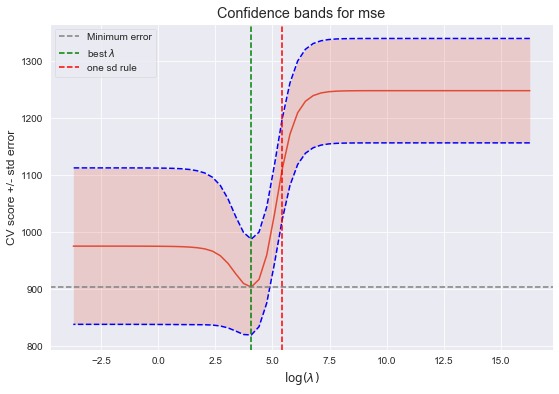

In [367]:
#plot
plt.figure(figsize=(9,6))
plt.plot(np.log10(lambdas), scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
plt.plot(np.log10(lambdas), scores + std_error, 'b--')
plt.plot(np.log10(lambdas), scores - std_error, 'b--')

plt.fill_between(np.log10(lambdas), scores + std_error, scores - std_error, alpha=0.2)
plt.ylabel('CV score +/- std error')
plt.xlabel(r'$\log(\lambda)$')
plt.axhline(np.min(scores), linestyle='--', color='.5', label='Minimum error')
plt.axvline(np.log10(best_lambd) , linestyle='dashed', color='green', label='best '+r'$\lambda$')
plt.axvline(np.log10(onesd), linestyle='dashed', color='red', label='one sd rule')
plt.legend()
plt.title('Confidence bands for mse') 

We see green vertical line is best lambda and red is one standard error rule. We observe that average MSE decreases until $\lambda_{best}$ is reached. For larger lambda the shrinkage becomes dominant and forces all coefficient towards zero (hence increase in average mse).

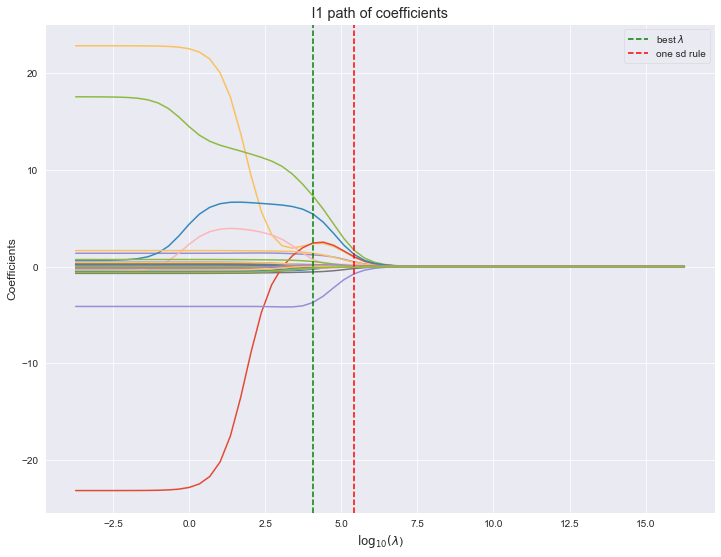

In [368]:
clf = Ridge(tol=0.01)
coefs_ = []

for alpha in lambdas:
    clf.set_params(alpha=alpha)
    clf.fit(X_train, np.ravel(y_train))
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.figure(figsize=(12,9))
plt.plot(np.log10(lambdas), coefs_) #proper value of lambda should be -np.log10(cs)
ymin, ymax = plt.ylim()
plt.xlabel(r'$\log_{10}(\lambda$)')
plt.ylabel('Coefficients')
plt.axvline(np.log10(best_lambd) , linestyle='dashed', color='green', label='best '+r'$\lambda$')
plt.axvline(np.log10(onesd), linestyle='dashed', color='red', label='one sd rule')
plt.legend()
plt.title('l1 path of coefficients')
plt.axis('tight')
plt.show()

## Best Lasso

In [369]:
best_lasso = cv.best_estimator_
print(best_lasso.coef_)

[-1.12284199e-01 -2.78097771e-01  1.20820382e+00 -5.60703294e-01
  2.36879717e+00  7.30865541e+00  7.29621404e-01  2.43632370e+00
  5.43491927e+00 -3.72629601e+00  1.18209057e-01  1.37802024e+00
  5.17274784e-01 -1.11321486e-01 -9.44840434e-03  7.87843090e-03
  1.97412720e-01  5.09267238e-03  1.44258241e-01 -1.25051842e-01
 -1.98950614e-01  7.77440184e-02 -8.92443591e-02  1.88117586e-01
 -1.44982059e-01  3.13852363e-02 -1.54853319e-01]


In [248]:
np.sum(best_lasso.coef_ != 0)

3

In [249]:
np.where(best_lasso.coef_ != 0)[0]
index_best = best_lasso.coef_!=0
index_best

array([False, False, False, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [250]:
np.where(best_lasso.coef_ == 0)[0]

array([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26])

In [251]:
X_test_best = X_test.loc[:,index_best]
X_test_best = sm.add_constant(X_test_best)

X_test_best
X_test.shape

(10238, 27)

In [252]:
results = sm.OLS(y_test, X_test_best).fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     1429.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:54:16   Log-Likelihood:                -49432.
No. Observations:               10238   AIC:                         9.887e+04
Df Residuals:                   10234   BIC:                         9.890e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4873      0.299     25.042      0.0

## Onesd Lasso

In [253]:
onesd_lasso = Lasso()
onesd_lasso.set_params(alpha=onesd)
onesd_lasso.fit(X_train, np.ravel(y_train))


Lasso(alpha=14.003737735077253, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [254]:
print(onesd_lasso.coef_)

[ 0.          0.          0.         -0.          0.          4.78053788
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.        ]


In [255]:
np.sum(onesd_lasso.coef_ != 0)

1

In [256]:
np.where(onesd_lasso.coef_ != 0)[0]
index_onesd = onesd_lasso.coef_!=0
np.where(onesd_lasso.coef_ == 0)[0]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

Now that we have found a well-performing model using only 25 predictors, there are several options. One may for instance fit a logistic regression to the test set, using the variables selected by the lasso, to obtain parameter estimates and p-values. Another option is to do bootstrapping on the training data, and fit lasso several times. This will not yield p-values, but interesting information can still be obtained, for example the proportion of times a variable is set to zero. In the following sections, both approaches are tested, starting with bootstrapping.

In [257]:
X_test_onesd = X_test.loc[:,index_onesd]
X_test_onesd = sm.add_constant(X_test_onesd)

X_test_onesd.head(5)

,const,comm24
1549,1.0,-0.015386
12072,1.0,-0.261745
39913,1.0,-0.287678
14330,1.0,-0.209880
31783,1.0,6.999353


In [258]:
results = sm.OLS(y_test, X_test_onesd).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     4001.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:54:40   Log-Likelihood:                -49534.
No. Observations:               10238   AIC:                         9.907e+04
Df Residuals:                   10236   BIC:                         9.909e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4743      0.302     24.752      0.0

## Bootstrap Lasso

In [259]:
from random import choices
def BSlasso( X, y, lambdas, B=1000, n_folds=10):
    N = len(y)
    p = X.shape[1]
    coefs_matrix = np.zeros((B,p)) # Bxp - matrix, each row contains coefficient values for one bootstrap sample
    error_matrix = np.zeros((B, len(lambdas))) # Bx len(cs), matrix, each row contains the error for one bootstrap sample
    
    
    for b in range(B):
        # print(b)
        bootstrap_indexes = choices(np.arange(N),k=N) # sampling k=N indexes with replacement
        #print(bootstrap_indexes)
        X_boot = X.iloc[bootstrap_indexes,:]
        y_boot = y.iloc[bootstrap_indexes]

        #Cross validation for bootstrap sample
        estimator = Lasso(tol=0.1)
        param_grid = {"alpha" : lambdas}
        cv = GridSearchCV(estimator, param_grid, cv=n_folds, scoring='neg_mean_squared_error')
        cv.fit(X_boot, y_boot)

        coefs_matrix[b,:] = cv.best_estimator_.coef_
        error_matrix[b, :] = -cv.cv_results_['mean_test_score'] #we use the best lambda

    zero_elements = np.zeros(p) # is element of this list counts the relative number of times each elements coeff are zero
    for j in range(p):
        zero_elements[j] = 1-(np.count_nonzero(coefs_matrix[:,j])/B) #how many times ==0

    return coefs_matrix, error_matrix, zero_elements

In [329]:
bootstrap_size=100
coefs, errors, zeros= BSlasso(X_train, y_train, lambdas, B=bootstrap_size, n_folds=10)

/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2984996.605376834, tolerance: 2859116.025745296
  positive)
/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3159454.336489992, tolerance: 2859116.025745296
  positive)
/Users/casperstenersen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3481054.1172771994, tolerance: 3166081.0643668524
  positive)


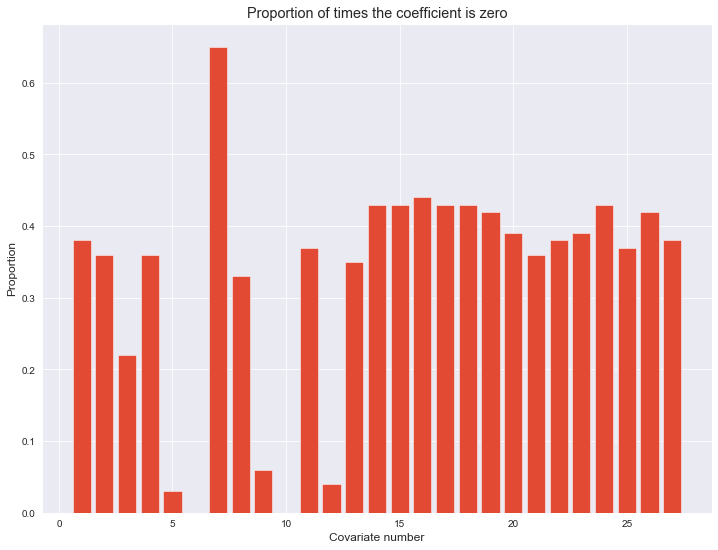

In [330]:
p = X_train.shape[1]
plt.figure(figsize=(12,9))
plt.bar(np.arange(1, p+1, 1), zeros)
plt.savefig("nonzero_coefs_B=%s.pdf" % bootstrap_size)
plt.title('Proportion of times the coefficient is zero') #proper title???
plt.xlabel('Covariate number')
plt.ylabel('Proportion')
plt.savefig('BSprops.png', dpi=500)
plt.show()

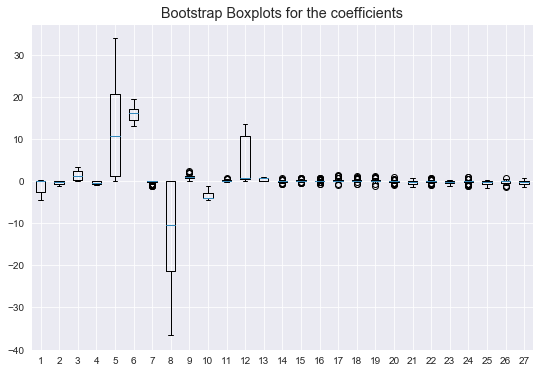

In [333]:

plt.figure(figsize=(9,6))
plt.boxplot(coefs)
plt.title('Bootstrap Boxplots for the coefficients')
plt.savefig("boxplot_coeffs_B=%s.pdf" % bootstrap_size, dpi = 600)
plt.show()